# Splines in PyMC3

:::{post} Oct 8, 2021 
:tags: patsy, pymc3.Deterministic, pymc3.Exponential, pymc3.Model, pymc3.Normal, regression, spline
:category: beginner
:author: Joshua Cook, Tyler James Burch
:::

## Introduction

Often, the model we want to fit is not a perfect line between some $x$ and $y$.
Instead, the parameters of the model are expected to vary over $x$.
There are multiple ways to handle this situation, one of which is to fit a *spline*.
The spline is effectively multiple individual lines, each fit to a different section of $x$, that are tied together at their boundaries, often called *knots*.
Below is an exmaple of how to fit a spline using the Bayesian framework [PyMC](https://docs.pymc.io).

Below is a full working example of how to fit a spline using PyMC. The data and model are taken from [*Statistical Rethinking* 2e](https://xcelab.net/rm/statistical-rethinking/) by [Richard McElreath's](https://xcelab.net/rm/) {cite:p}`mcelreath2018statistical`.
As the book uses [Stan](https://mc-stan.org) (another advanced probabilitistic programming language), the modeling code is primarily taken from the [GitHub repository of the PyMC implementation of *Statistical Rethinking*](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb).
My contributions are primarily of explanation and additional analyses of the data and results.

**Note that this is not a comprehensive review of splines – I primarily focus on the implementation in PyMC.**
For more information on this method of non-linear modeling, I suggesting beginning with chapter 7.4 "Regression Splines" of *An Introduction to Statistical Learning* {cite:p}`james2021statisticallearning`.

## Setup

For this example, I employ the standard data science and Bayesian data analysis packages.
In addition, the ['patsy'](https://patsy.readthedocs.io/en/latest/) library is used to generate the basis for the spline (more on that below).

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm

from patsy import dmatrix

/home/fonnesbeck/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

## Cherry blossom data

The data for this example was the number of days (`doy` for "days of year") that the cherry trees were in bloom in each year (`year`). 
Years missing a `doy` were dropped.

In [3]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [4]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


After dropping rows with missing data, there are 827 years with the numbers of days in which the trees were in bloom.

In [5]:
blossom_data.shape

(827, 5)

Below is a plot of the data we will be modeling showing the number of days of bloom per year.

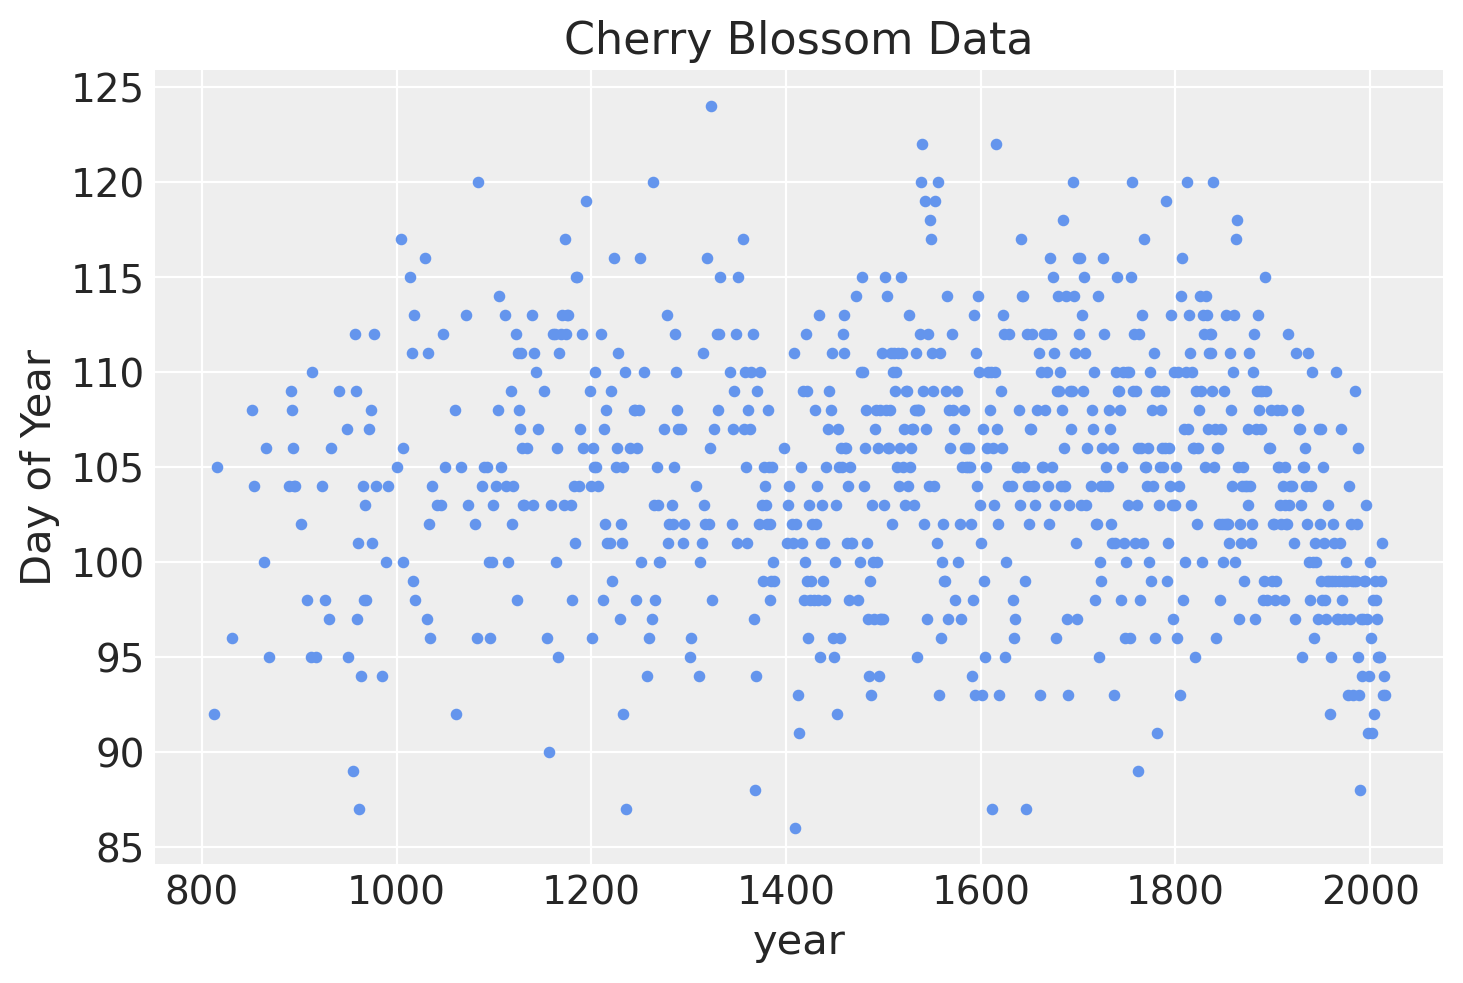

In [6]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
);

## The model

We will fit the following model.

$D \sim \mathcal{N}(\mu, \sigma)$  
$\quad \mu = a + Bw$  
$\qquad a \sim \mathcal{N}(100, 10)$  
$\qquad w \sim \mathcal{N}(0, 10)$  
$\quad \sigma \sim \text{Exp}(1)$

The number of days of bloom $D$ will be modeled as a normal distribution with mean $\mu$ and standard deviation $\sigma$. In turn, the mean will be a linear model composed of a y-intercept $a$ and spline defined by the basis $B$ multiplied by the model parameter $w$ with a variable for each region of the basis. Both have relatively weak normal priors.

### Prepare the spline

The spline will have 15 *knots*, splitting the year into 16 sections (including the regions covering the years before and after those in which we have data). The knots are the boundaries of the spline, the name owing to how the individual lines will be tied together at these boundaries to make a continuous and smooth curve.  The knots will be unevenly spaced over the years such that each region will have the same proportion of data.

In [7]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

Below is a plot of the locations of the knots over the data.

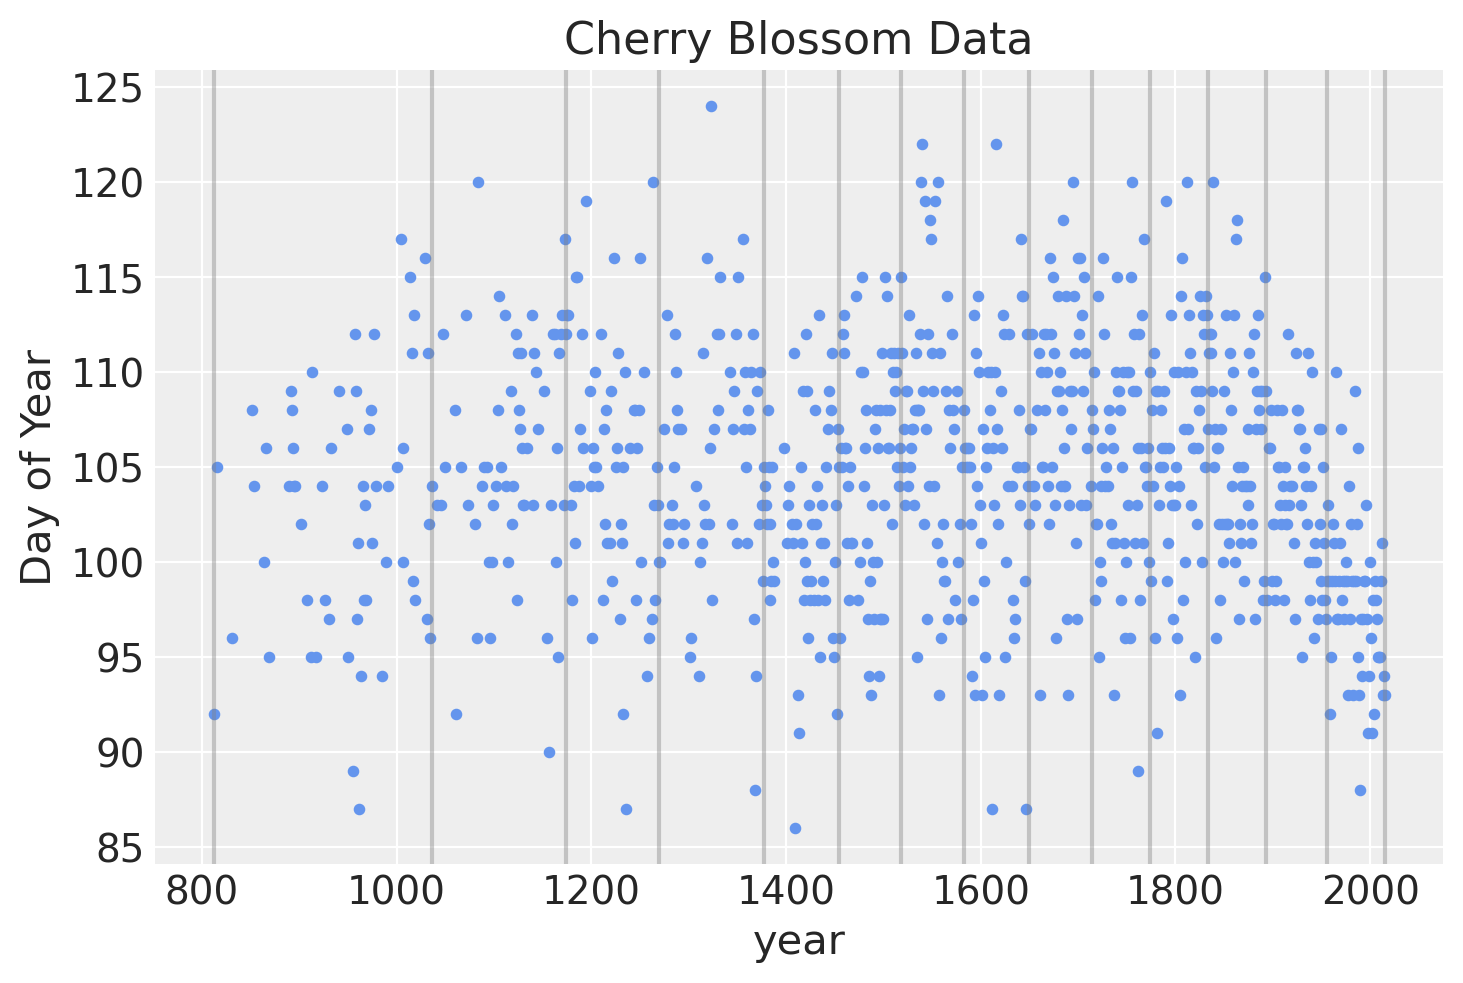

In [8]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

Before doing any Bayesian modeling of the spline, we can get an idea of what our model should look like using the lowess modeling from `statsmodels`

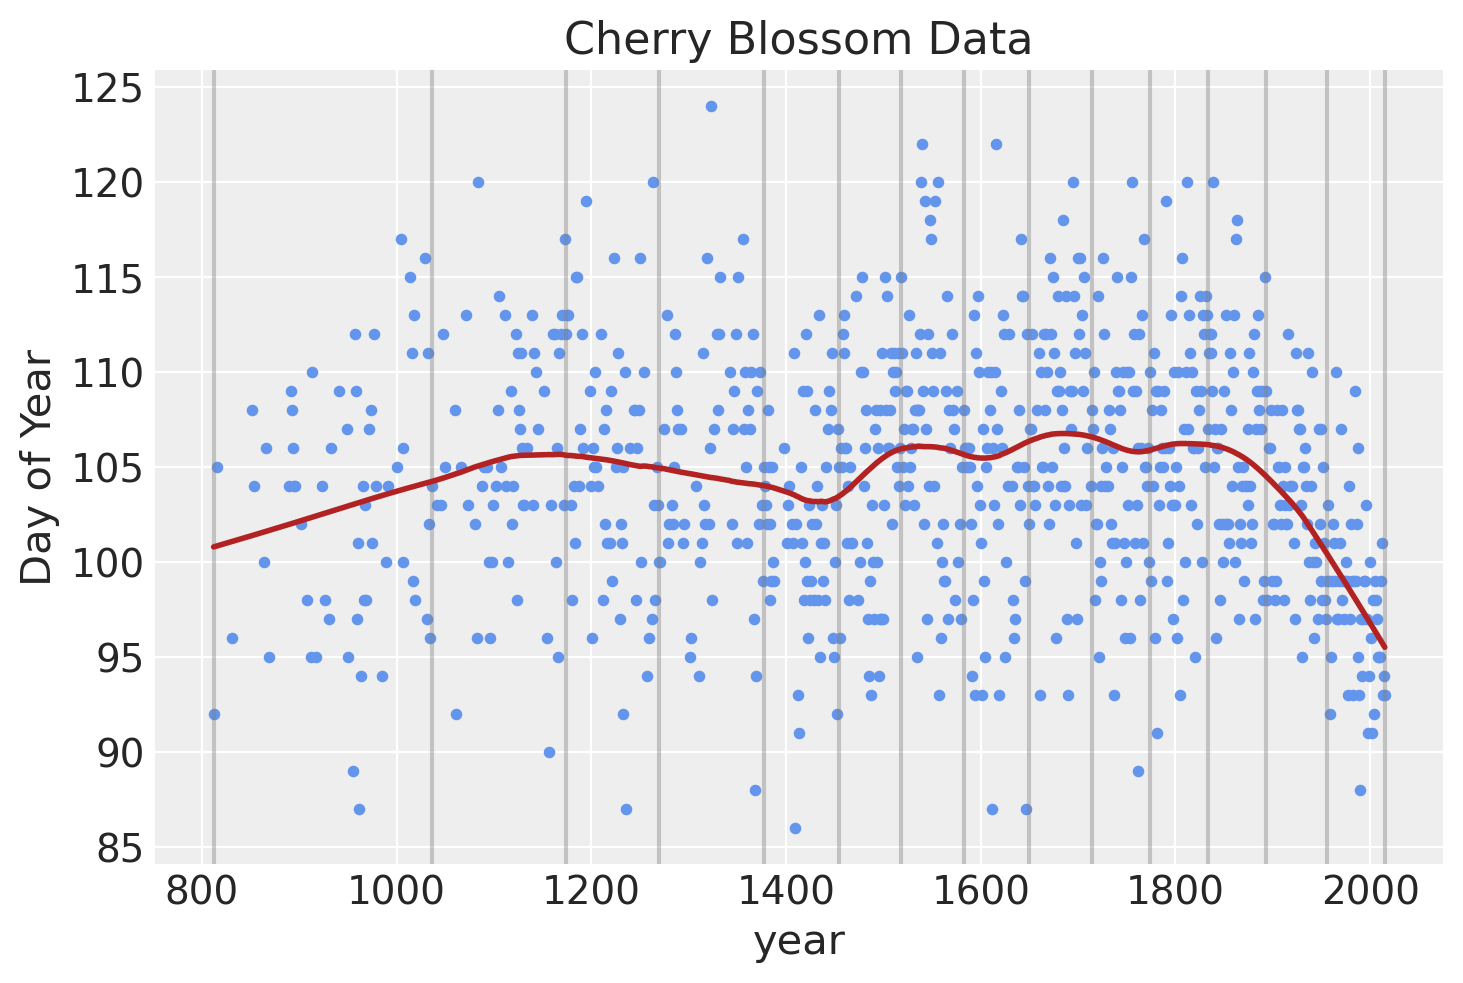

In [9]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

lowess = sm.nonparametric.lowess
lowess_data = lowess(blossom_data.doy, blossom_data.year, frac=0.2, it=10)
plt.plot(lowess_data[:, 0], lowess_data[:, 1], color="firebrick", lw=2);

Another way of visualizing what the spline should look like is to plot individual linear models over the data between each knot. 
The spline will effectively be a compromise between these individual models and a continuous curve.

In [10]:
blossom_data["knot_group"] = [np.where(a <= knot_list)[0][0] for a in blossom_data.year]
blossom_data["knot_group"] = pd.Categorical(blossom_data["knot_group"], ordered=True)

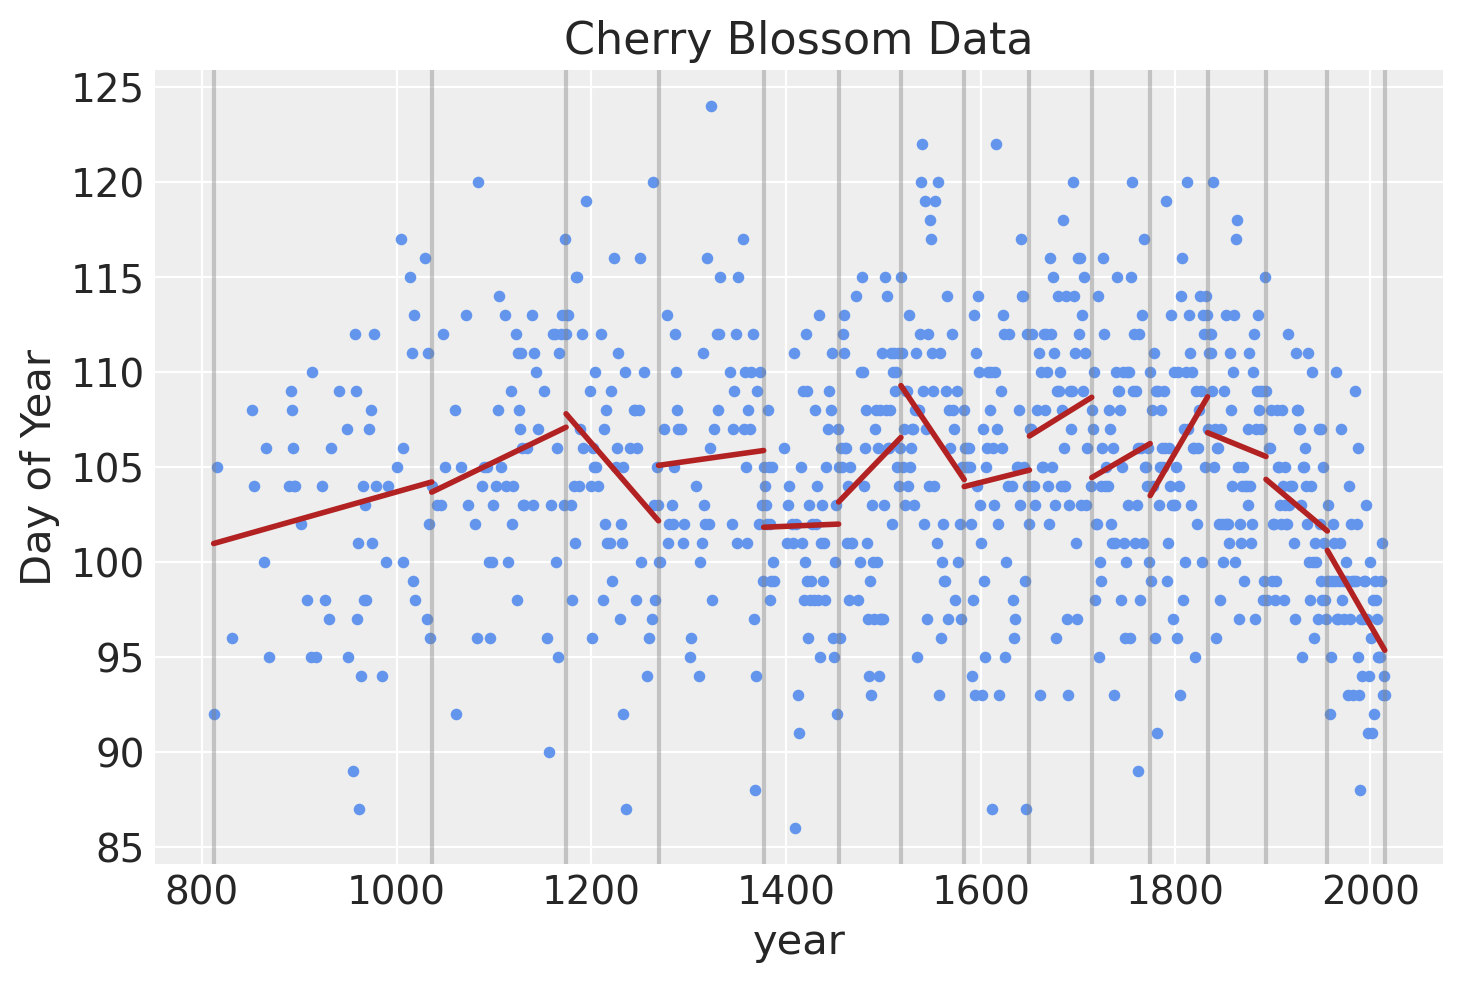

In [11]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

for i in np.arange(len(knot_list) - 1):

    # Subset data to knot
    x_range = (knot_list[i], knot_list[i + 1])
    subset = blossom_data.query(f"year > {x_range[0]} & year <= {x_range[1]}")

    # Create a linear model and predict values
    lm = sm.OLS(subset.doy, sm.add_constant(subset.year, prepend=False)).fit()
    x_vals = np.linspace(x_range[0], x_range[1], 100)
    y_vals = lm.predict(sm.add_constant(x_vals, prepend=False))
    # Add to plot
    plt.plot(x_vals, y_vals, color="firebrick", lw=2)

Finally we can use `patsy` to create the matrix $B$ that will be the b-spline basis for the regression.
The degree is set to 3 to create a cubic b-spline.

In [12]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

The b-spline basis is plotted below, showing the *domain* of each piece of the spline. The height of each curve indicates how influential the corresponding model covariate (one per spline region) will be on model's inference of that region. The overlapping regions represent the knots, showing how the smooth transition from one region to the next is formed.

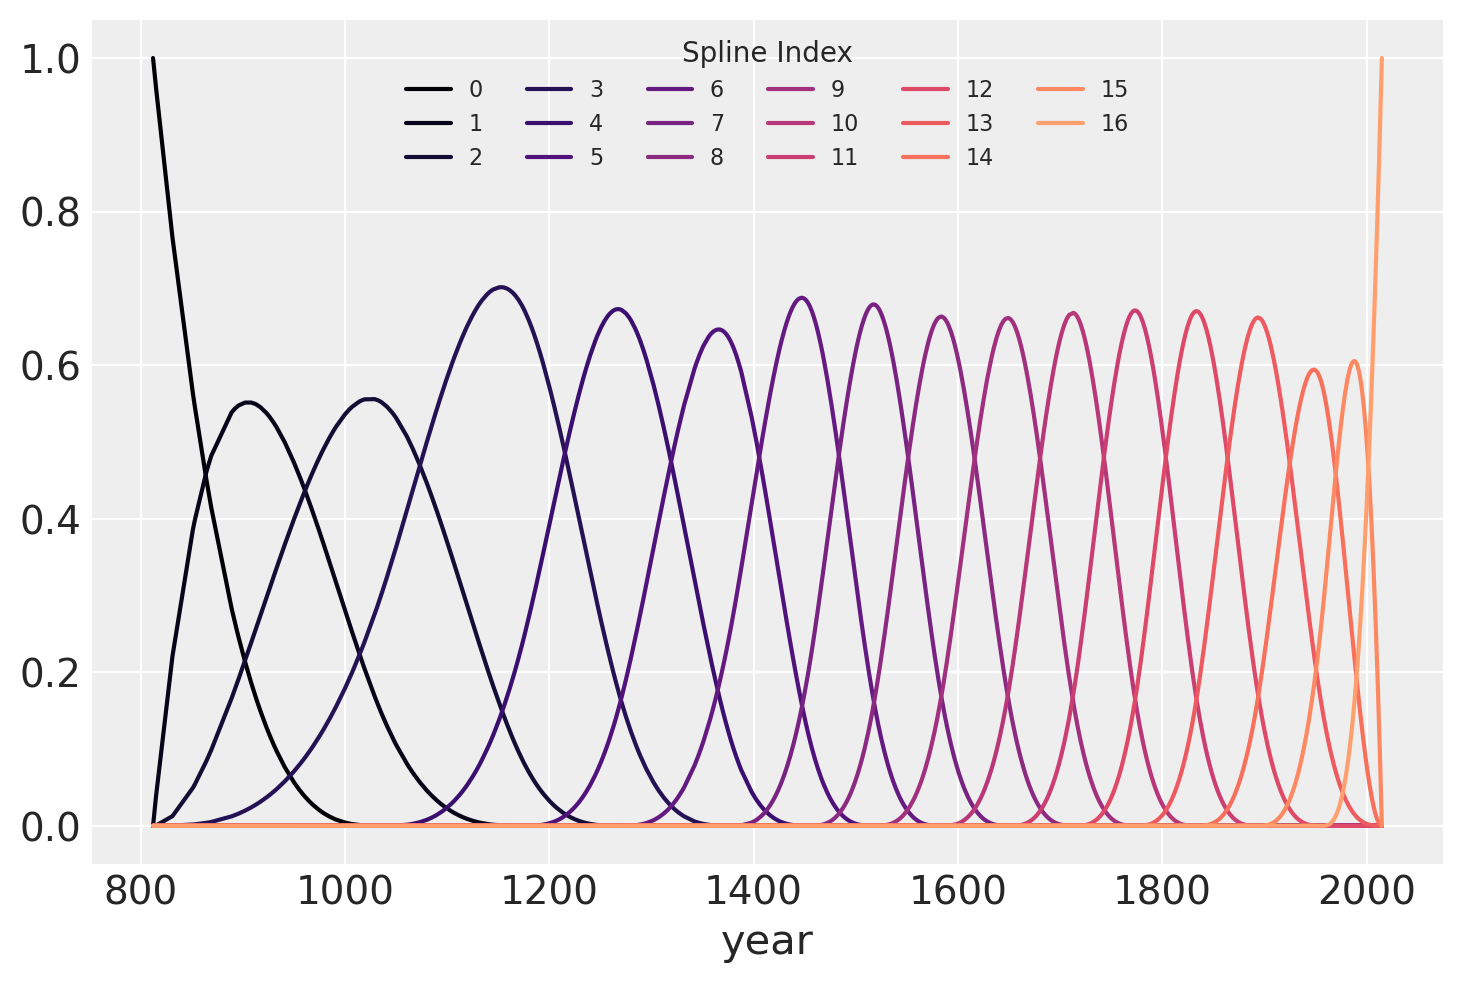

In [13]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

### Fit the model

Finally, the model can be built using PyMC. A graphical diagram shows the organization of the model parameters (note that this requires the installation of `python-graphviz`, which I recommend doing in a `conda` virtual environment).

In [14]:
COORDS = {"obs": np.arange(len(blossom_data.doy)), "splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sd=3, dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=blossom_data.doy, dims="obs")

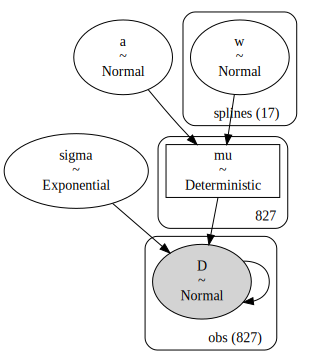

In [15]:
pm.model_to_graphviz(spline_model)

In [16]:
with spline_model:
    prior_pred = pm.sample_prior_predictive()
    trace = pm.sample(
        draws=1000,
        tune=1000,
        random_seed=RANDOM_SEED,
        chains=4,
        return_inferencedata=True,
    )
    post_pred = pm.sample_posterior_predictive(trace)
    trace.extend(az.from_pymc3(prior=prior_pred, posterior_predictive=post_pred))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.


ModuleNotFoundError: No module named 'pymc3'

## Analysis

Now we can analyze the draws from the posterior of the model.

### Parameter Estimates

Below is a table summarizing the posterior distributions of the model parameters.
The posteriors of $a$ and $\sigma$ are quite narrow while those for $w$ are wider.
This is likely because all of the data points are used to estimate $a$ and $\sigma$ whereas only a subset are used for each value of $w$.
(It could be interesting to model these hierarchically allowing for the sharing of information and adding regularization across the spline.) 
The effective sample size and $\widehat{R}$ values all look good, indiciating that the model has converged and sampled well from the posterior distribution.

In [ ]:
az.summary(trace, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,103.629,0.770,102.183,105.072,0.018,0.013,1778.0,2057.0,1.0
w[0],-1.778,2.201,-5.824,2.322,0.033,0.026,4491.0,3049.0,1.0
w[1],-1.636,2.065,-5.666,2.050,0.035,0.028,3588.0,3202.0,1.0
w[2],-0.245,1.934,-3.808,3.386,0.033,0.029,3373.0,2971.0,1.0
w[3],3.364,1.486,0.673,6.304,0.027,0.019,2938.0,2749.0,1.0
w[4],0.199,1.504,-2.525,3.014,0.027,0.020,3215.0,3082.0,1.0
w[5],2.098,1.587,-0.876,4.977,0.029,0.021,2996.0,3163.0,1.0
w[6],-3.557,1.475,-6.397,-0.766,0.026,0.019,3109.0,2866.0,1.0
w[7],5.529,1.453,2.827,8.254,0.027,0.019,2992.0,3056.0,1.0
w[8],-0.030,1.555,-2.987,2.825,0.027,0.021,3450.0,3259.0,1.0


The trace plots of the model parameters look good (homogeneous and no sign of trend), further indicating that the chains converged and mixed.

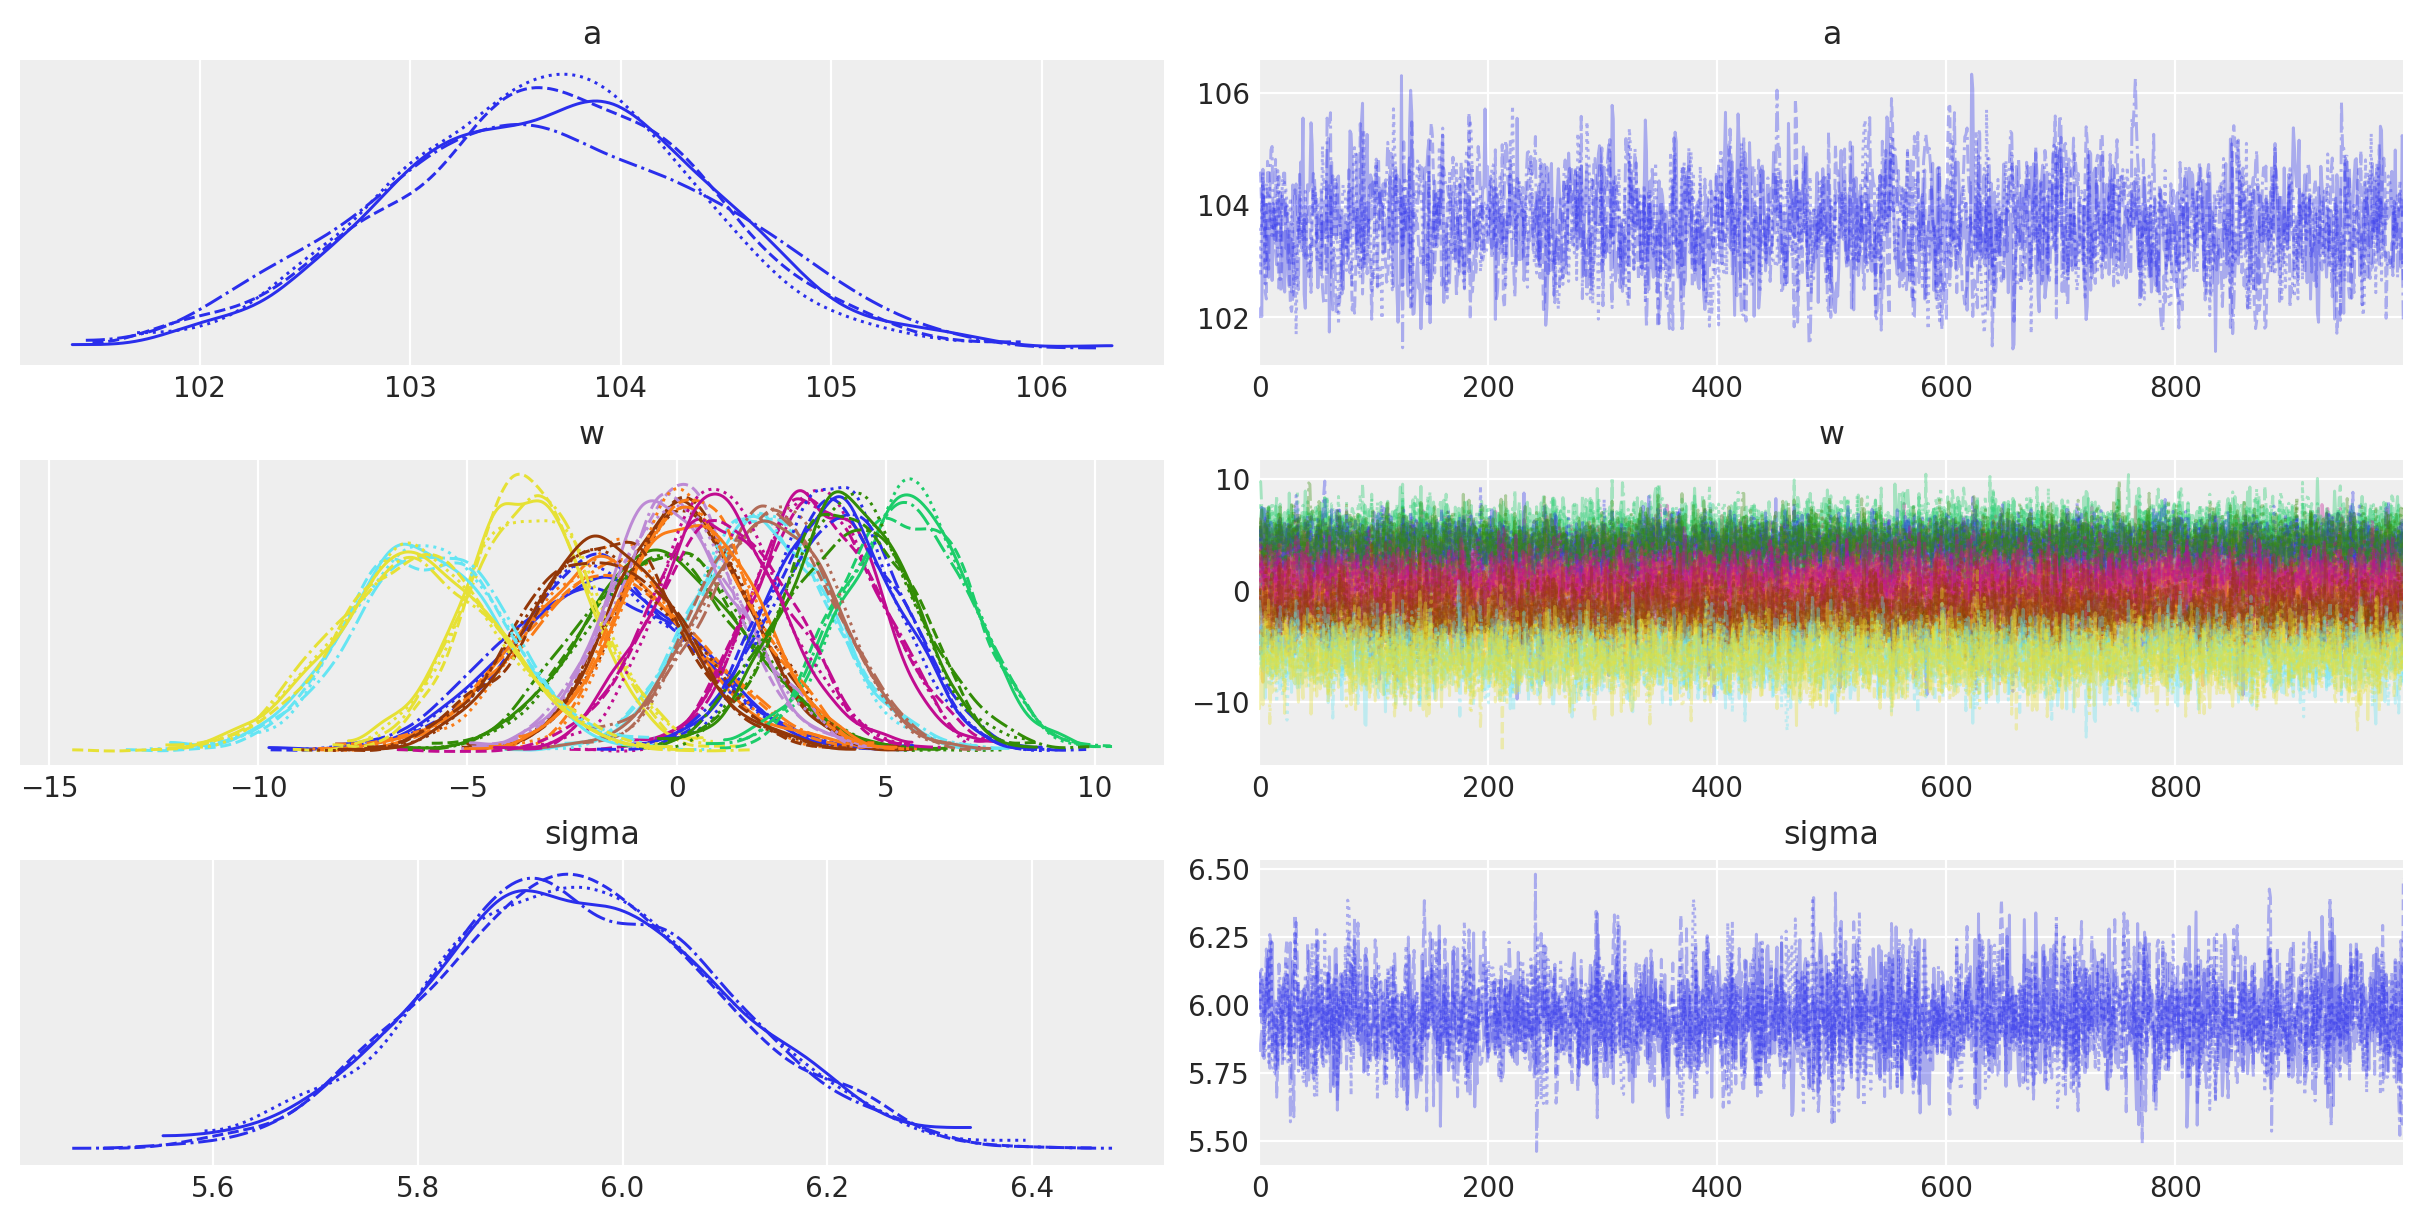

In [ ]:
az.plot_trace(trace, var_names=["a", "w", "sigma"]);

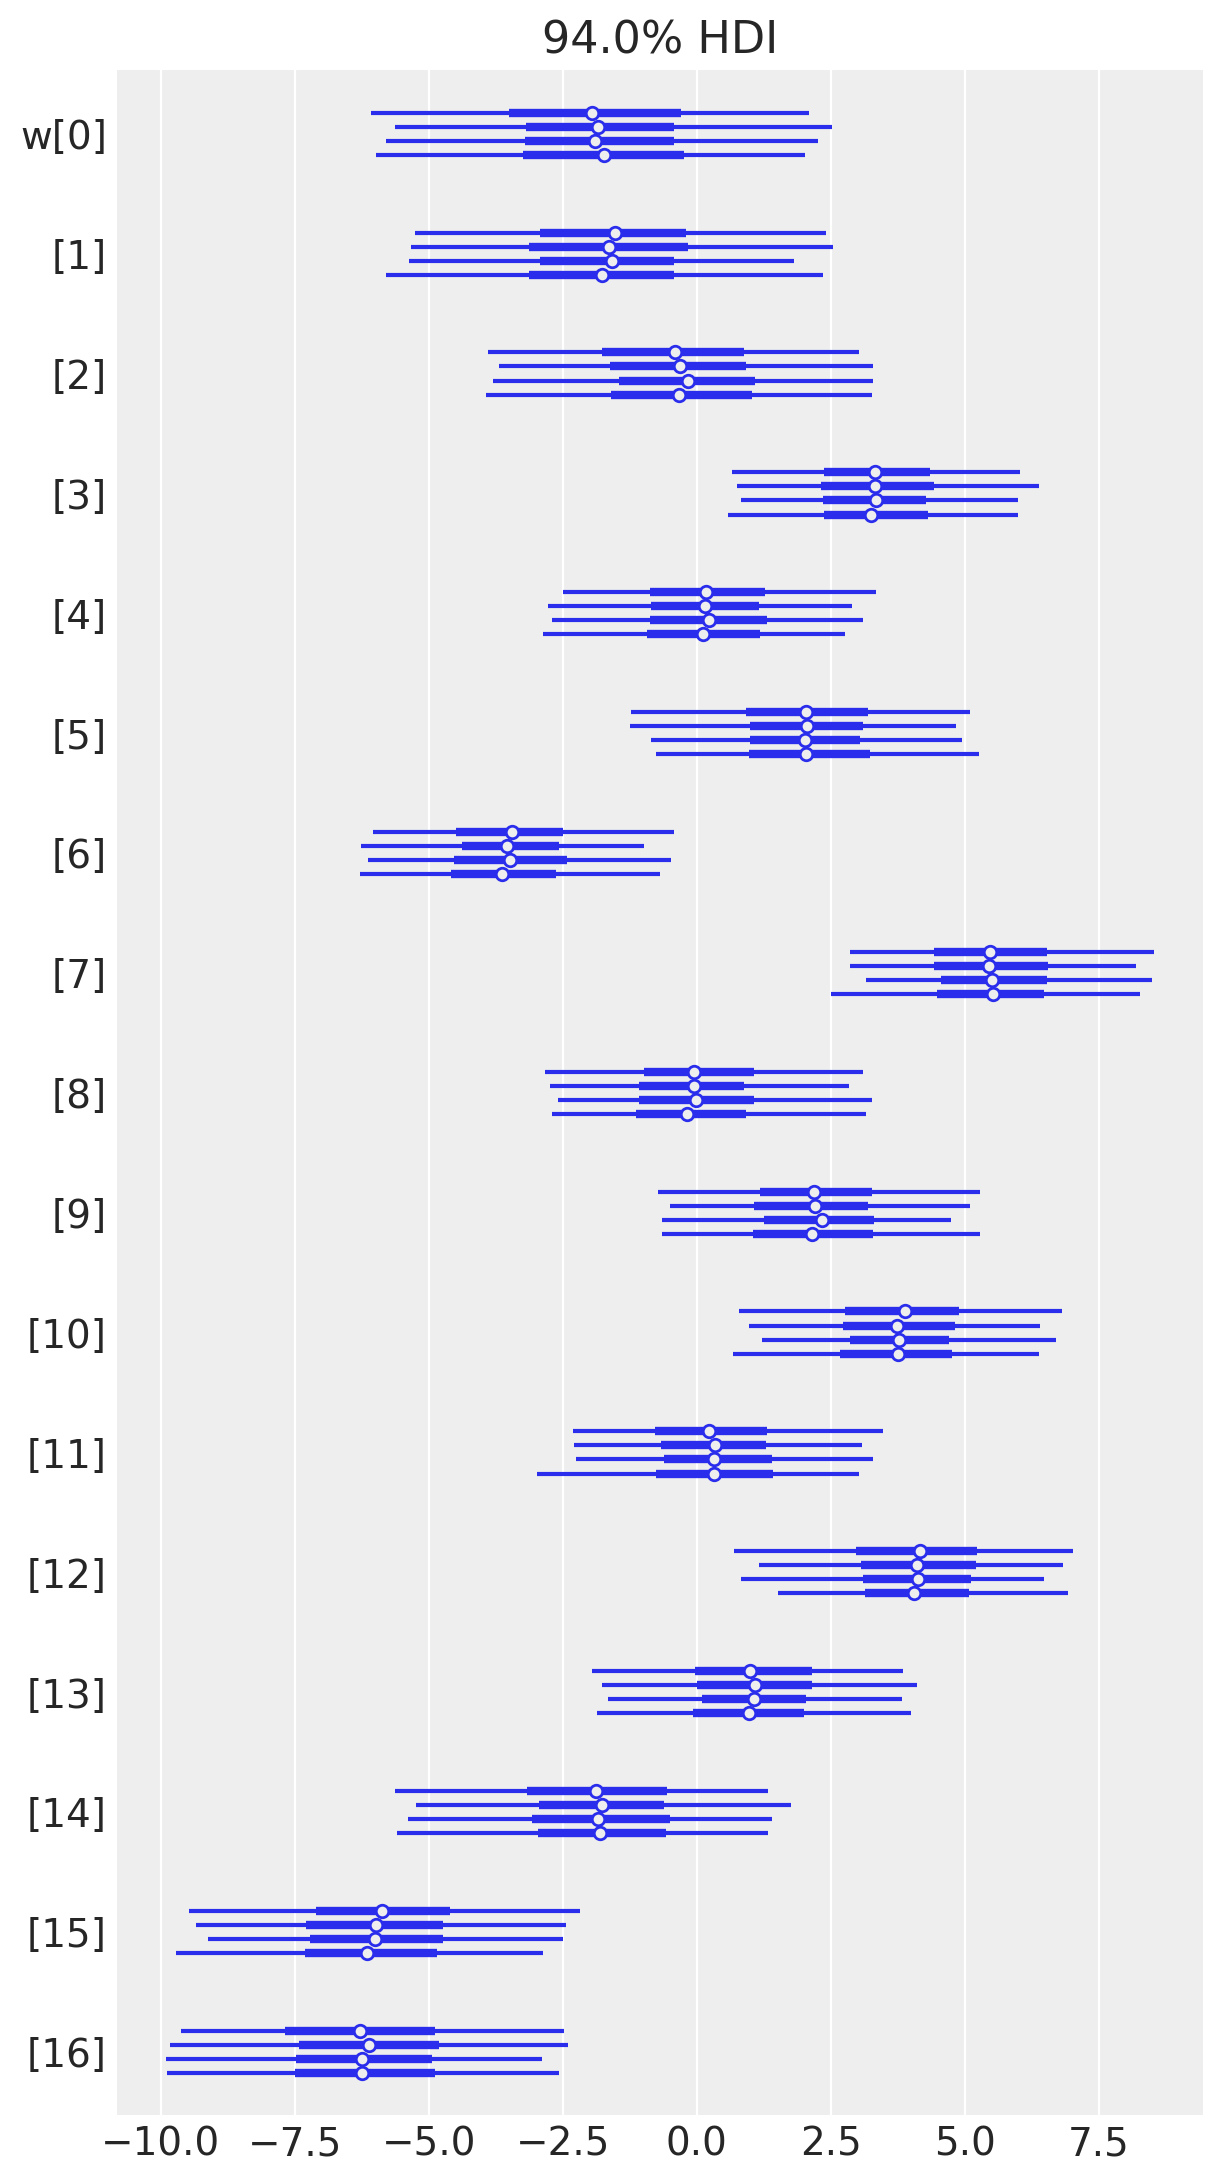

In [ ]:
az.plot_forest(trace, var_names=["w"], combined=False);

Another visualization of the fit spline values is to plot them multiplied against the basis matrix.
The knot boundaries are shown as vertical lines again, but now the spline basis is multipled against the values of $w$ (represented as the rainbow-colored curves). The dot product of $B$ and $w$ – the actual computation in the linear model – is shown in black.

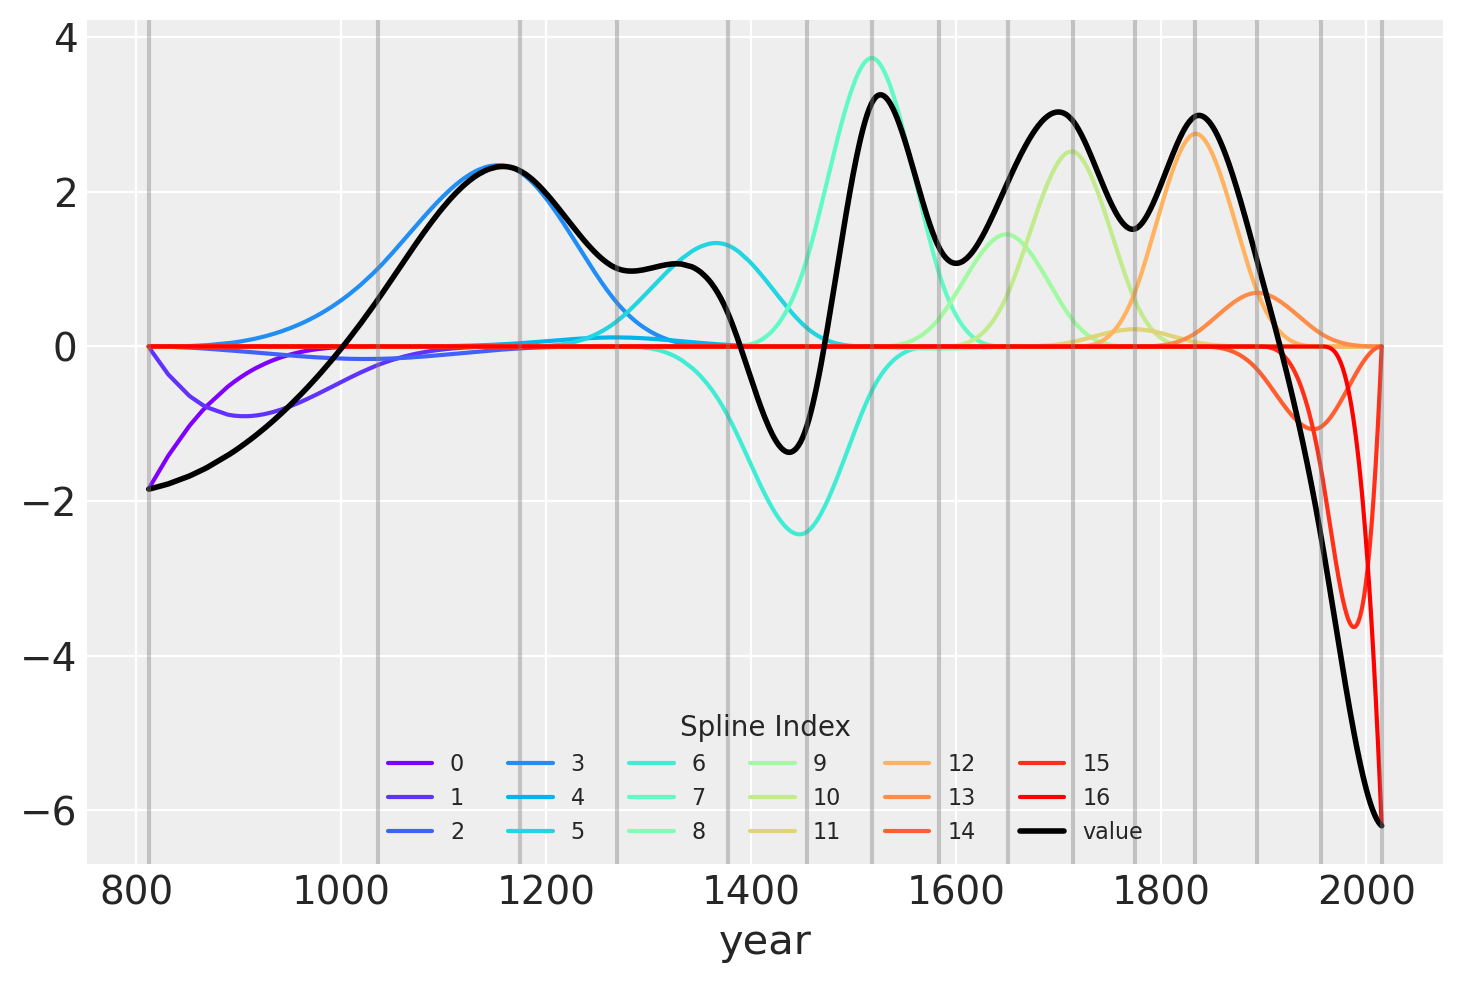

In [ ]:
wp = trace.posterior["w"].values.mean(axis=(0, 1))

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("year", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

### Model predictions

Lastly, we can visualize the predictions of the model using the posterior predictive check.

In [ ]:
post_pred = az.summary(trace, var_names=["mu"]).reset_index(drop=True)
blossom_data_post = blossom_data.copy().reset_index(drop=True)
blossom_data_post["pred_mean"] = post_pred["mean"]
blossom_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
blossom_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

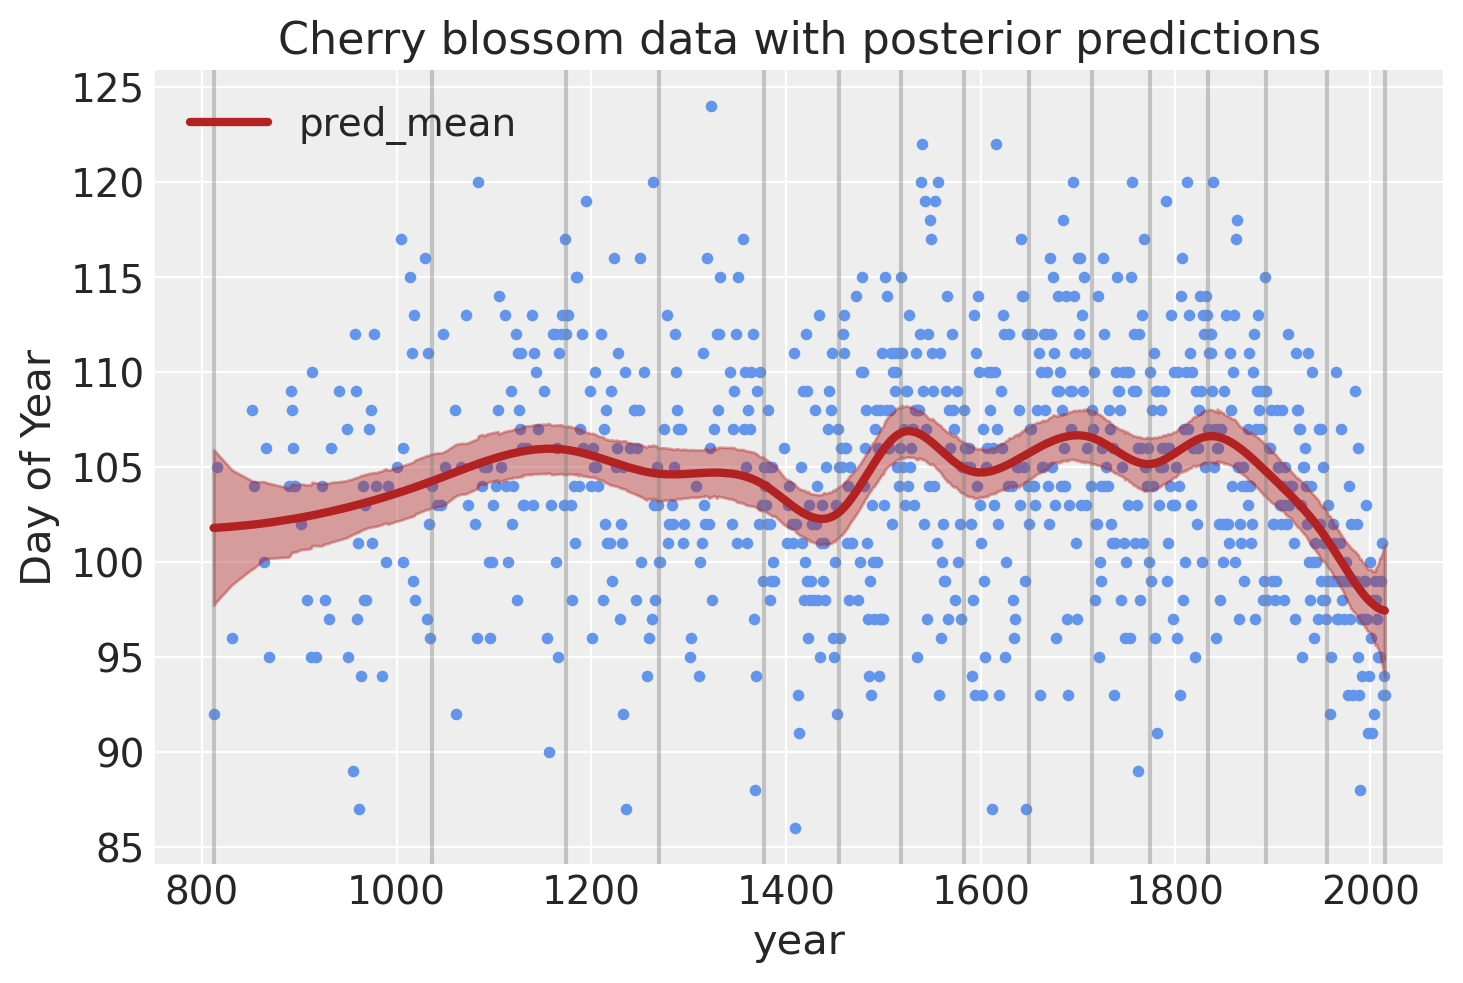

In [ ]:
blossom_data.plot.scatter(
    "year",
    "doy",
    color="cornflowerblue",
    s=10,
    title="Cherry blossom data with posterior predictions",
    ylabel="Day of Year",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

blossom_data_post.plot("year", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    blossom_data_post.year,
    blossom_data_post.pred_hdi_lower,
    blossom_data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

## Authors

- Authored by Joshua Cook in October, 2021
- Updated by [Tyler James Burch](https://github.com/tjburch) in October, 2021

## References

:::{bibliography}
:filter: docname in docnames
:::

I would like to recognize the discussion ["Spline Regression in PyMC3"](https://discourse.pymc.io/t/spline-regression-in-pymc3/6235) on the PyMC Discourse as the inspiration of this example and for the helpful discussion and problem-solving that improved it further.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray,patsy

Last updated: Sun Jan 30 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

aesara: 2.3.6
xarray: 0.20.2
patsy : 0.5.2

sys        : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]
arviz      : 0.11.4
numpy      : 1.22.1
statsmodels: 0.13.1
pymc       : 4.0.0b2
pandas     : 1.4.0
matplotlib : 3.5.1

Watermark: 2.3.0



:::{include} ../page_footer.md
:::